In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import folium
import geopandas as gpd
from datetime import datetime

In [84]:
registros_filtrados = pd.read_excel("registros_filtrados.xlsx")
sensores = pd.read_excel("../sensores_airenuevoleon.xlsx")

In [85]:
registros_filtrados["PM25"].isna().groupby(registros_filtrados["Sensor_id"]).sum()

# TODO: insertar horas que no hayan sido tomadas en consideracion para cada sensor como null completo

Sensor_id
ANL1     12677
ANL10    15387
ANL11    20650
ANL12    14703
ANL13    14607
ANL15    32231
ANL16    14314
ANL2     10373
ANL3     12581
ANL4     11517
ANL5      9597
ANL6     15888
ANL7     23998
ANL8      9621
ANL9     16857
Name: PM25, dtype: int64

# Análisis de Lecturas Atípicas y Consistencia


## Introducción
Breve texto sobre el objetivo del análisis y la metodología usada

### ¿Cómo interpretar los intervalos de confianza 1σ, 2σ, 3σ?

Para cada sensor ANL, calculamos la media y la desviación estándar de las lecturas de los contaminantes.  
Las líneas de colores en cada gráfico representan los siguientes límites estadísticos:

- **±1σ (naranja)**: abarca aproximadamente el 68% de los datos esperados
- **±2σ (rojo)**: abarca el 95% de los datos esperados
- **±3σ (morado)**: abarca el 99.7% de los datos esperados

Valores que se encuentran por fuera de estas bandas son **posibles lecturas atípicas o inconsistentes**, especialmente si ocurren con frecuencia o en múltiples sensores.

Esto permite validar la estabilidad del sensor y detectar problemas de lectura o condiciones ambientales extremas.


**Nota:** Aunque los intervalos de confianza calculados incluyen valores negativos, estos no representan concentraciones reales de contaminantes. Se muestran únicamente como referencia estadística.

In [86]:
def resumen_calidad_sensor(df, variable, nombre_variable=None):
    """
    Calcula el resumen de calidad de los datos por sensor:
    total de registros, nulos, inconsistentes (<0), y sus porcentajes.

    Parámetros:
    - df: DataFrame con los registros (debe incluir Sensor_id, variable)
    - variable: nombre de la columna a evaluar (str)
    - nombre_variable: nombre para mostrar en el título (str), opcional

    Retorna:
    - DataFrame con el resumen de calidad
    """

    if nombre_variable is None:
        nombre_variable = variable

    total = df[variable].groupby(df["Sensor_id"]).size()
    nulos = df[variable].isna().groupby(df["Sensor_id"]).sum()
    inconsistentes = df[variable].lt(0).groupby(df["Sensor_id"]).sum()

    resumen = pd.DataFrame({
        "Total registros": total,
        "Nulos": nulos,
        "Inconsistentes (<0)": inconsistentes
    })

    resumen["% Nulos"] = (resumen["Nulos"] / resumen["Total registros"] * 100).round(2)
    resumen["% Inconsistentes"] = (resumen["Inconsistentes (<0)"] / resumen["Total registros"] * 100).round(2)

    resumen = resumen.fillna(0).sort_values(by="% Nulos", ascending=False)

    print(f"Resumen de calidad – {nombre_variable}")
    return resumen


In [87]:
def graficar_intervalos_confianza(df, sensores_df, variable, nombre_variable=None):
    """
    Genera subplots por sensor con los intervalos de confianza 1,2,3 sigmas
    para la variable dada (PM2.5, O3, etc.).

    Parámetros:
    - df: DataFrame con los registros
    - sensores_df: DataFrame con los sensores válidos (ANL)
    - variable: nombre de la columna a analizar (str)
    - nombre_variable: nombre legible para títulos y ejes (str), opcional
    """

    if nombre_variable is None:
        nombre_variable = variable

    df_validos = df[df[variable].notnull() & (df[variable] >= 0)].copy()

    sensores_anl = sensores_df["Sensor_id"].unique()
    df_validos = df_validos[df_validos["Sensor_id"].isin(sensores_anl)]

    stats = df_validos.groupby("Sensor_id")[variable].agg(["mean", "std"]).dropna()

    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(18, 16))
    axs = axs.flatten()

    for i, sensor in enumerate(sensores_anl):
        df_sensor = df_validos[df_validos["Sensor_id"] == sensor]

        if df_sensor.empty or sensor not in stats.index:
            continue

        media = stats.loc[sensor, "mean"]
        std = stats.loc[sensor, "std"]

        axs[i].xaxis.set_major_locator(mdates.YearLocator())
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        axs[i].plot(df_sensor["Dia"], df_sensor[variable], alpha=0.5, label=nombre_variable)
        axs[i].axhline(media, color="green", linestyle="--", label="Media")
        axs[i].axhline(media + std, color="orange", linestyle="--", label="±1σ")
        axs[i].axhline(media - std, color="orange", linestyle="--")
        axs[i].axhline(media + 2*std, color="red", linestyle="--", label="±2σ")
        axs[i].axhline(media - 2*std, color="red", linestyle="--")
        axs[i].axhline(media + 3*std, color="purple", linestyle="--", label="±3σ")
        axs[i].axhline(media - 3*std, color="purple", linestyle="--")
        axs[i].set_title(sensor)
        axs[i].set_ylabel(nombre_variable)
        axs[i].set_ylim(bottom=0)
        

    plt.suptitle(f"{nombre_variable} – Intervalos de confianza por sensor (1σ, 2σ, 3σ)", fontsize=16)
    plt.xlabel("Fecha")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(loc="upper right")
    plt.show()


# Contaminante PM2.5

## Calidad de los Datos – PM2.5

Antes de analizar la variabilidad con intervalos de confianza, evaluamos la calidad de las mediciones de PM2.5 por sensor ANL.
El siguiente resumen muestra el porcentaje de lecturas faltantes (nulas) y lecturas inconsistentes (valores negativos).

In [88]:
resumen_calidad_sensor(registros_filtrados, "PM25", "PM2.5")

Resumen de calidad – PM2.5


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL15,32743,32231,469,98.44,1.43
ANL16,14923,14314,511,95.92,3.42
ANL7,56837,23998,33,42.22,0.06
ANL11,56858,20650,62,36.32,0.11
ANL9,56863,16857,14,29.64,0.02
ANL6,56834,15888,14,27.96,0.02
ANL10,56866,15387,22,27.06,0.04
ANL12,56853,14703,8,25.86,0.01
ANL13,56853,14607,11,25.69,0.02


## Distribución - PM2.5
Esta sección analiza la distribución de los valores de PM2.5 por sensor ANL, aplicando intervalos de confianza con 1σ, 2σ y 3σ (desviación estándar).
Esto nos permite detectar posibles lecturas atípicas o inconsistentes que se desvían significativamente de los valores esperados.

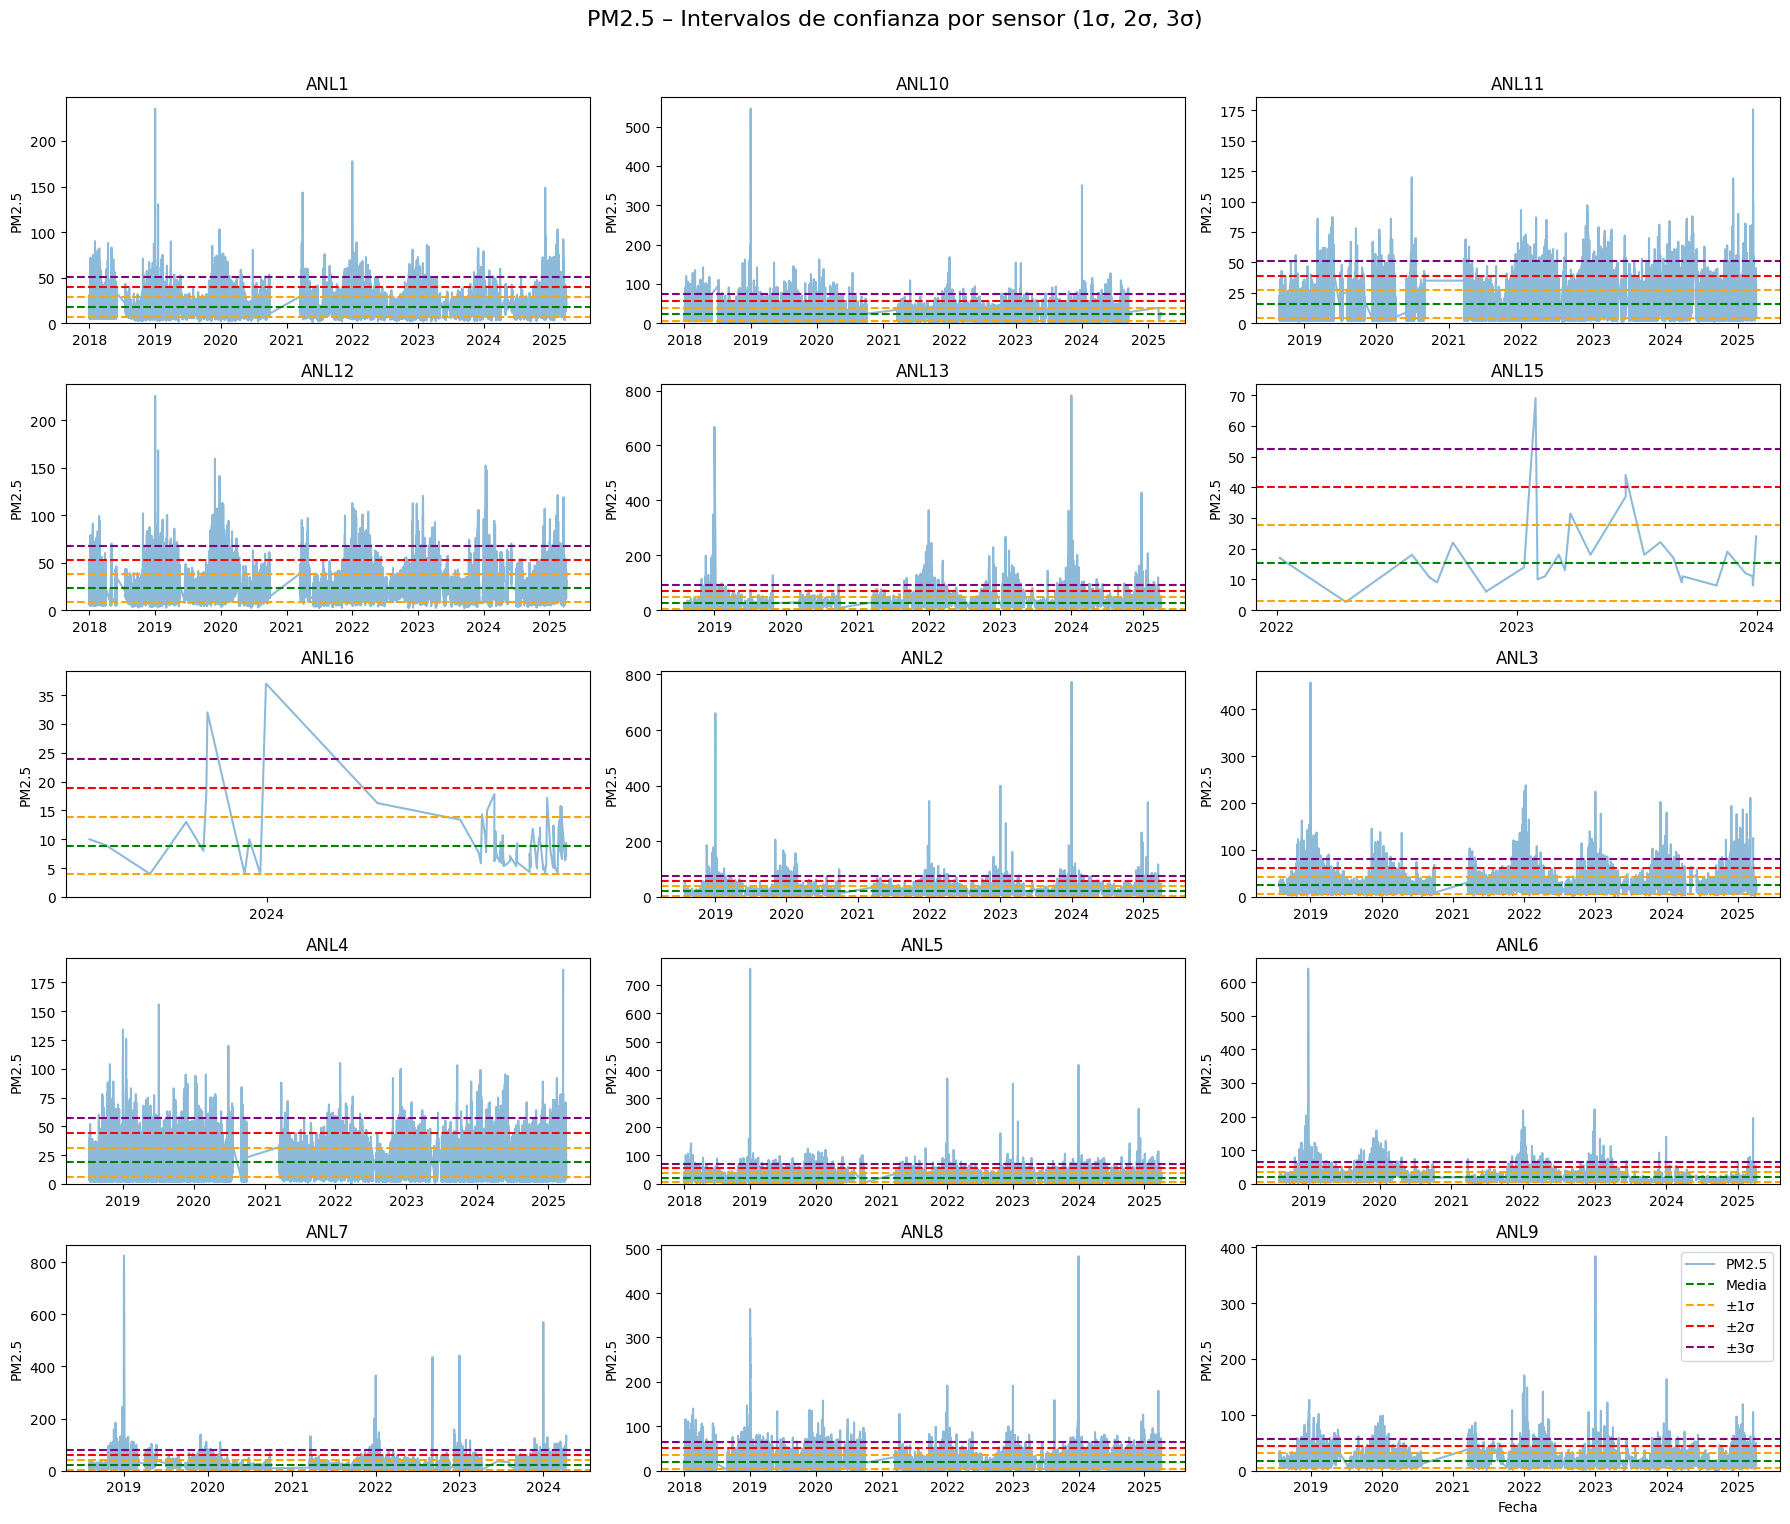

In [89]:
graficar_intervalos_confianza(registros_filtrados, sensores, "PM25", "PM2.5")

### Filtrado de datos

Para poder realizar extrapolaciones de datos de forma confiable es necesario que el porcentaje de registros nulos de cada sensor sea no mayora al 30%. La mayoria de los sensores parece tener una consistencia de datos de buena calidad a partir de mediados del 2021. 

In [112]:
START_DATETIME = datetime(day=1, month=6, year=2021, second=0, minute=0)

In [113]:
resumen_calidad_sensor(registros_filtrados[registros_filtrados["Dia"] > START_DATETIME], "PM25", "PM2.5")

Resumen de calidad – PM2.5


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL15,30970,30466,461,98.37,1.49
ANL16,14923,14314,511,95.92,3.42
ANL7,30974,15718,33,50.75,0.11
ANL1,30976,8275,3,26.71,0.01
ANL6,30971,8249,14,26.63,0.05
ANL10,31003,7972,22,25.71,0.07
ANL12,30990,7256,8,23.41,0.03
ANL11,30995,6989,60,22.55,0.19
ANL9,31000,6322,14,20.39,0.05


# Contaminante PM10

## Calidad de los Datos - PM10

In [114]:
resumen_calidad_sensor(registros_filtrados, "PM10", "PM10")

Resumen de calidad – PM10


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL9,56863,6003,3,10.56,0.01
ANL15,32743,2876,25,8.78,0.08
ANL1,56839,4423,1,7.78,0.00
ANL7,56837,4400,2,7.74,0.00
ANL16,14923,1110,80,7.44,0.54
ANL13,56853,3821,3,6.72,0.01
ANL10,56866,3674,2,6.46,0.00
ANL4,56846,3615,3,6.36,0.01
ANL6,56834,3495,3,6.15,0.01


## Distribución PM10

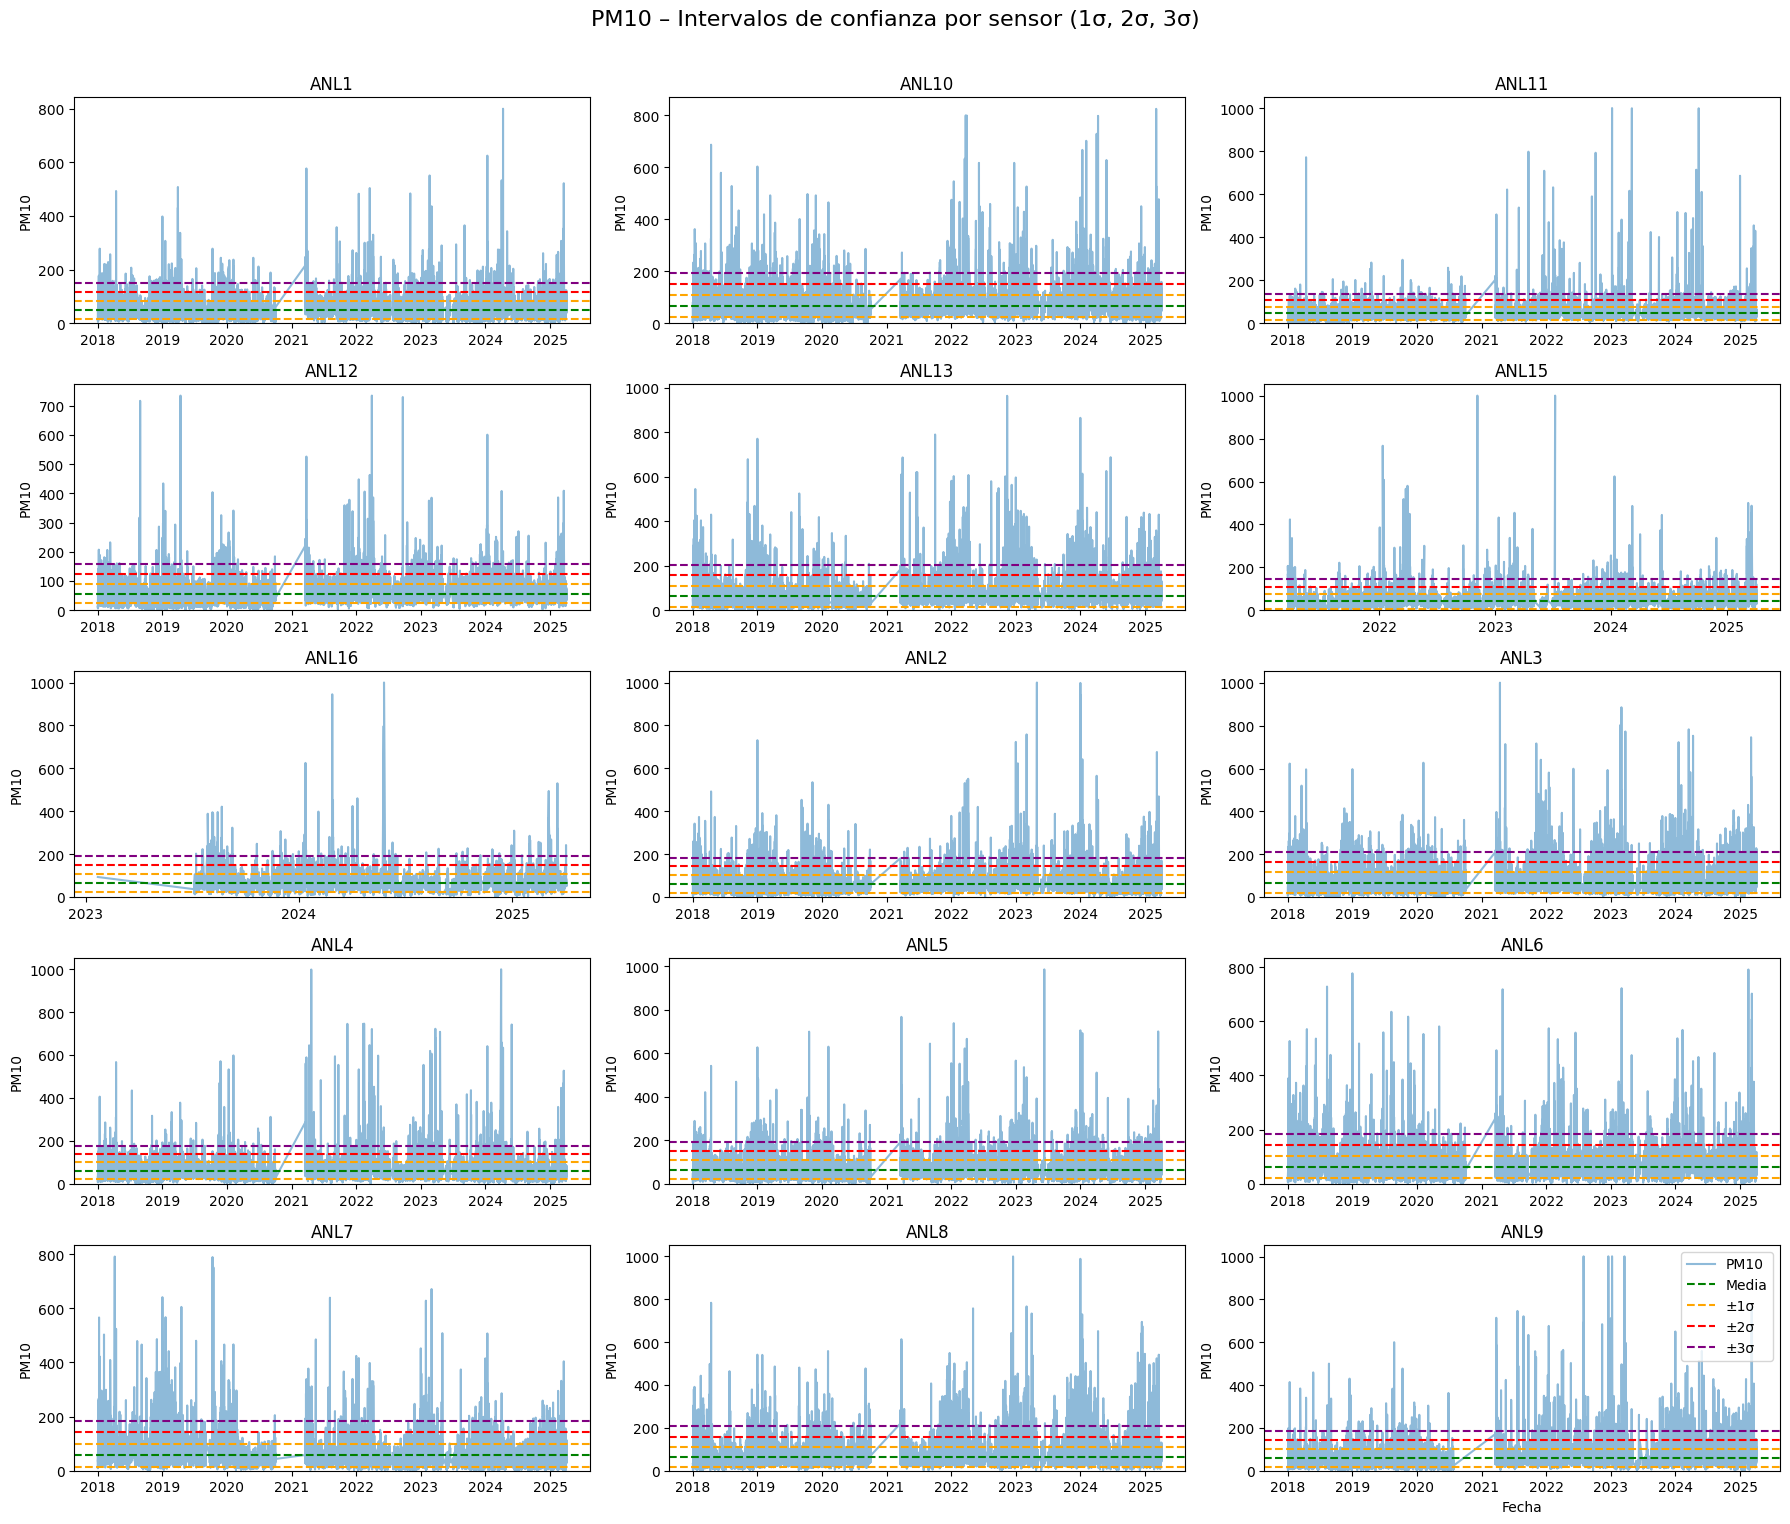

In [93]:
graficar_intervalos_confianza(registros_filtrados, sensores, "PM10", "PM10")

Evaluamos el impacto de hacer el corte en start datetime y nos damos cuenta de que es poco

In [115]:
resumen_calidad_sensor(registros_filtrados[registros_filtrados["Dia"] > START_DATETIME], "PM10", "PM10")

Resumen de calidad – PM10


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL9,31000,3226,3,10.41,0.01
ANL1,30976,2878,1,9.29,0.00
ANL15,30970,2806,25,9.06,0.08
ANL7,30974,2729,2,8.81,0.01
ANL6,30971,2521,3,8.14,0.01
ANL16,14923,1110,80,7.44,0.54
ANL10,31003,1994,2,6.43,0.01
ANL13,30990,1990,2,6.42,0.01
ANL3,30957,1921,3,6.21,0.01


# Contaminante O3

## Calidad de los Datos - O3

In [94]:
resumen_calidad_sensor(registros_filtrados, "O3", "Ozono")

Resumen de calidad – Ozono


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL9,56863,26785,1,47.10,0.00
ANL10,56866,25827,2,45.42,0.00
ANL13,56853,24429,7,42.97,0.01
ANL11,56858,23043,4,40.53,0.01
ANL6,56834,21714,3,38.21,0.01
ANL7,56837,20149,1,35.45,0.00
ANL5,56830,18654,5,32.82,0.01
ANL2,56835,14238,0,25.05,0.00
ANL3,56820,12857,5,22.63,0.01


## Distribución - O3 

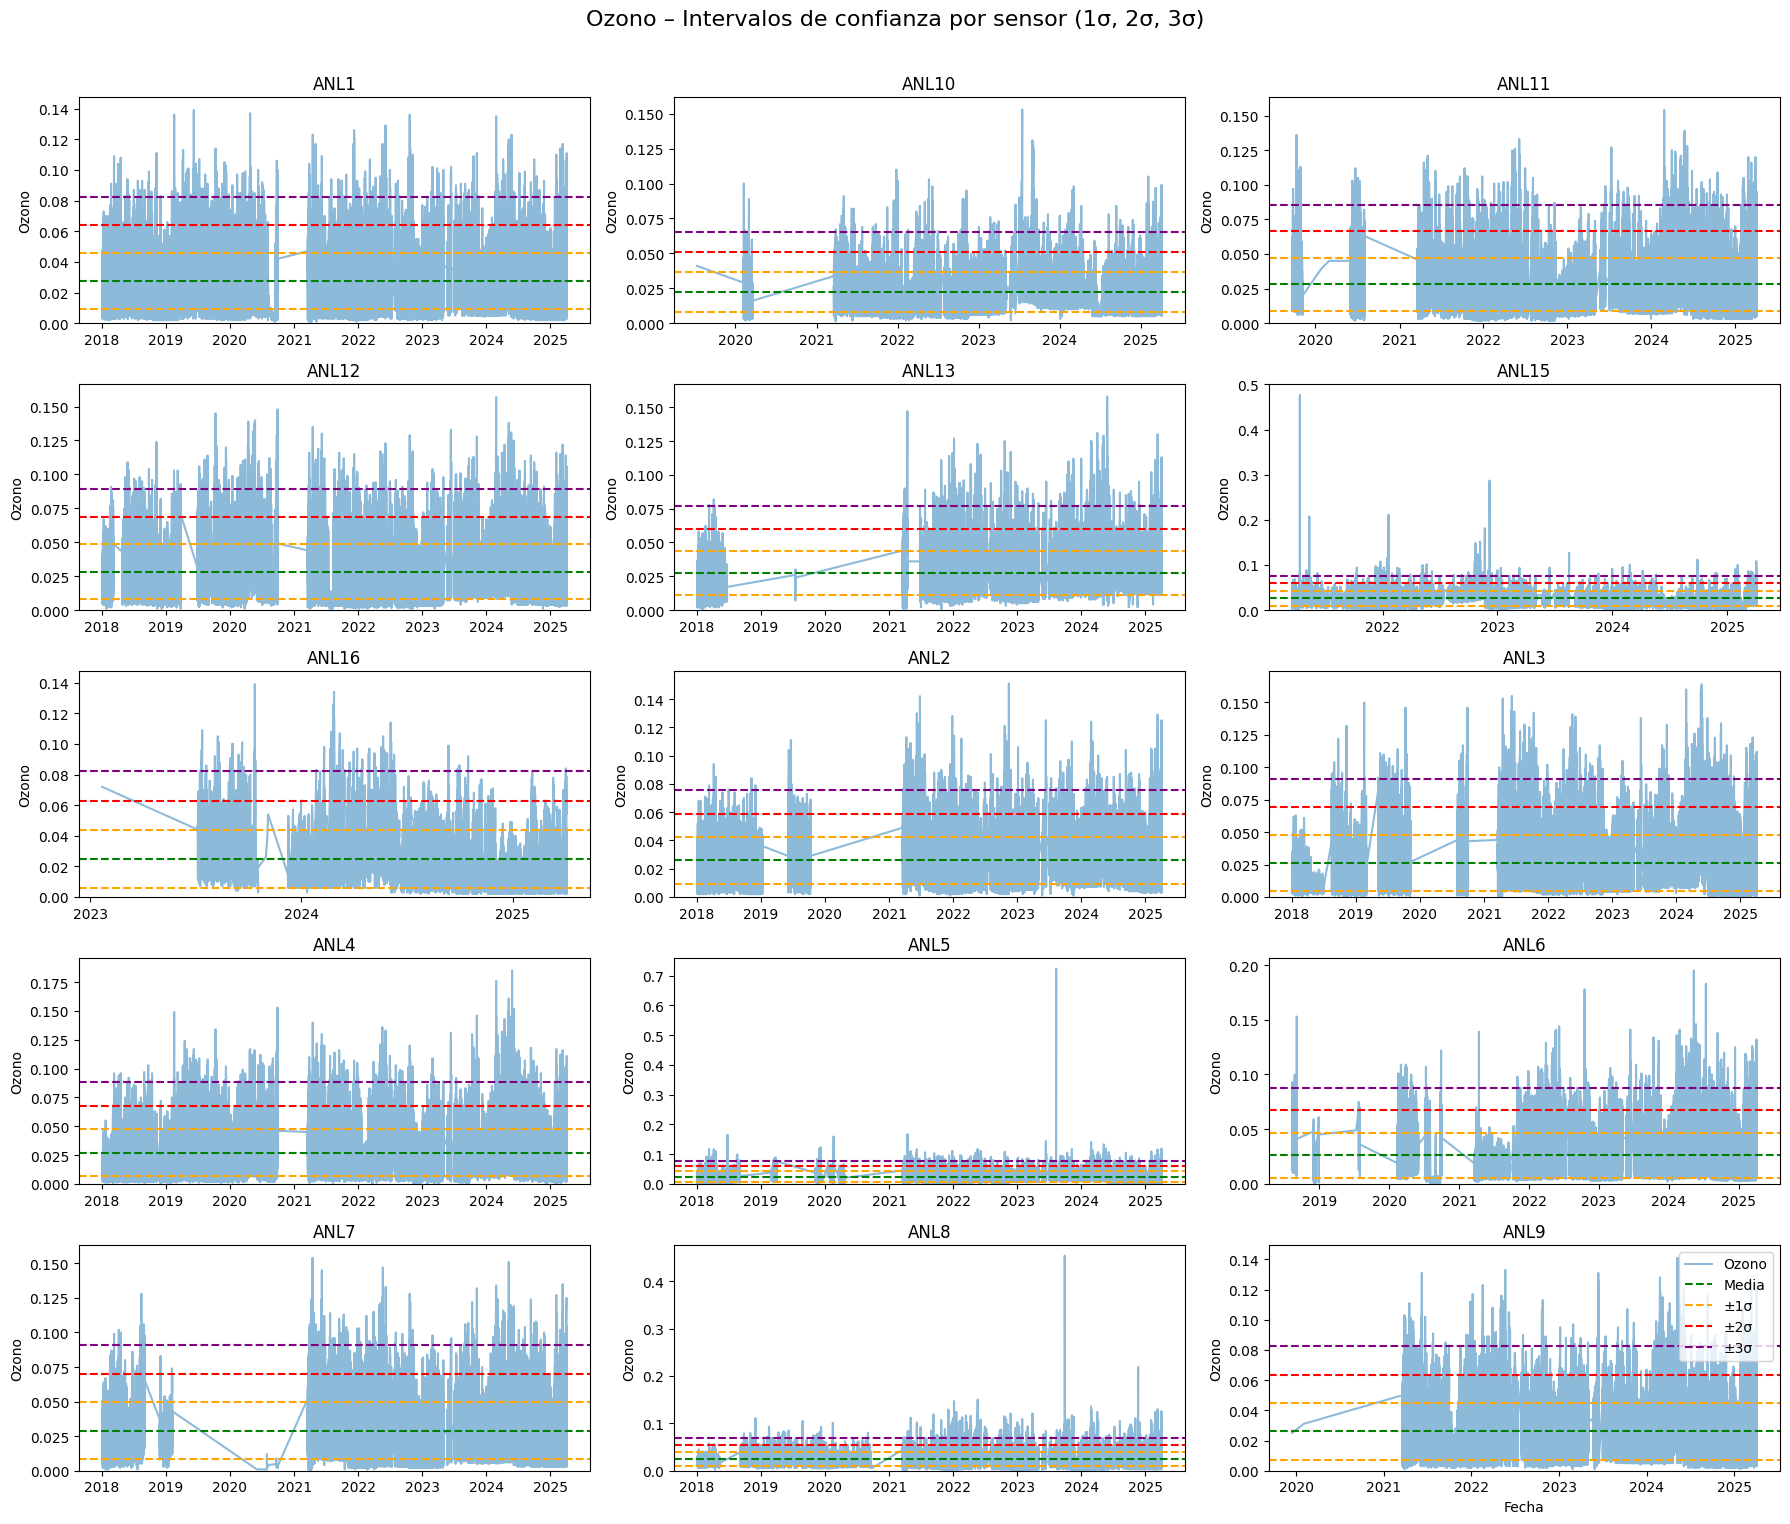

In [95]:
graficar_intervalos_confianza(registros_filtrados, sensores, "O3", "Ozono")

Evaluamos el impacto del corte en START_DATETIME en la calidad de datos de O3 y concluimos que tomando en cuenta ese corte, todos los sensores tienen pocentajes de nulos aceptables

In [117]:
resumen_calidad_sensor(registros_filtrados[registros_filtrados["Dia"] > START_DATETIME], "O3", "Ozono")

Resumen de calidad – Ozono


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL16,14923,1821,12,12.20,0.08
ANL13,30990,3112,3,10.04,0.01
ANL7,30974,2993,1,9.66,0.00
ANL15,30970,2958,30,9.55,0.10
ANL1,30976,2735,1,8.83,0.00
ANL6,30971,2688,3,8.68,0.01
ANL9,31000,2667,1,8.60,0.00
ANL3,30957,2648,3,8.55,0.01
ANL10,31003,2400,2,7.74,0.01


# Contaminante CO

## Calidad de los Datos – CO

In [96]:
resumen_calidad_sensor(registros_filtrados, "CO", "Monóxido de Carbono")

Resumen de calidad – Monóxido de Carbono


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL13,56853,25429,1,44.73,0.00
ANL7,56837,23096,1,40.64,0.00
ANL2,56835,19250,0,33.87,0.00
ANL11,56858,18654,17,32.81,0.03
ANL9,56863,17148,6,30.16,0.01
ANL10,56866,14328,3,25.20,0.01
ANL1,56839,12363,5,21.75,0.01
ANL3,56820,12118,12,21.33,0.02
ANL12,56853,11969,3,21.05,0.01


## Distribución - CO

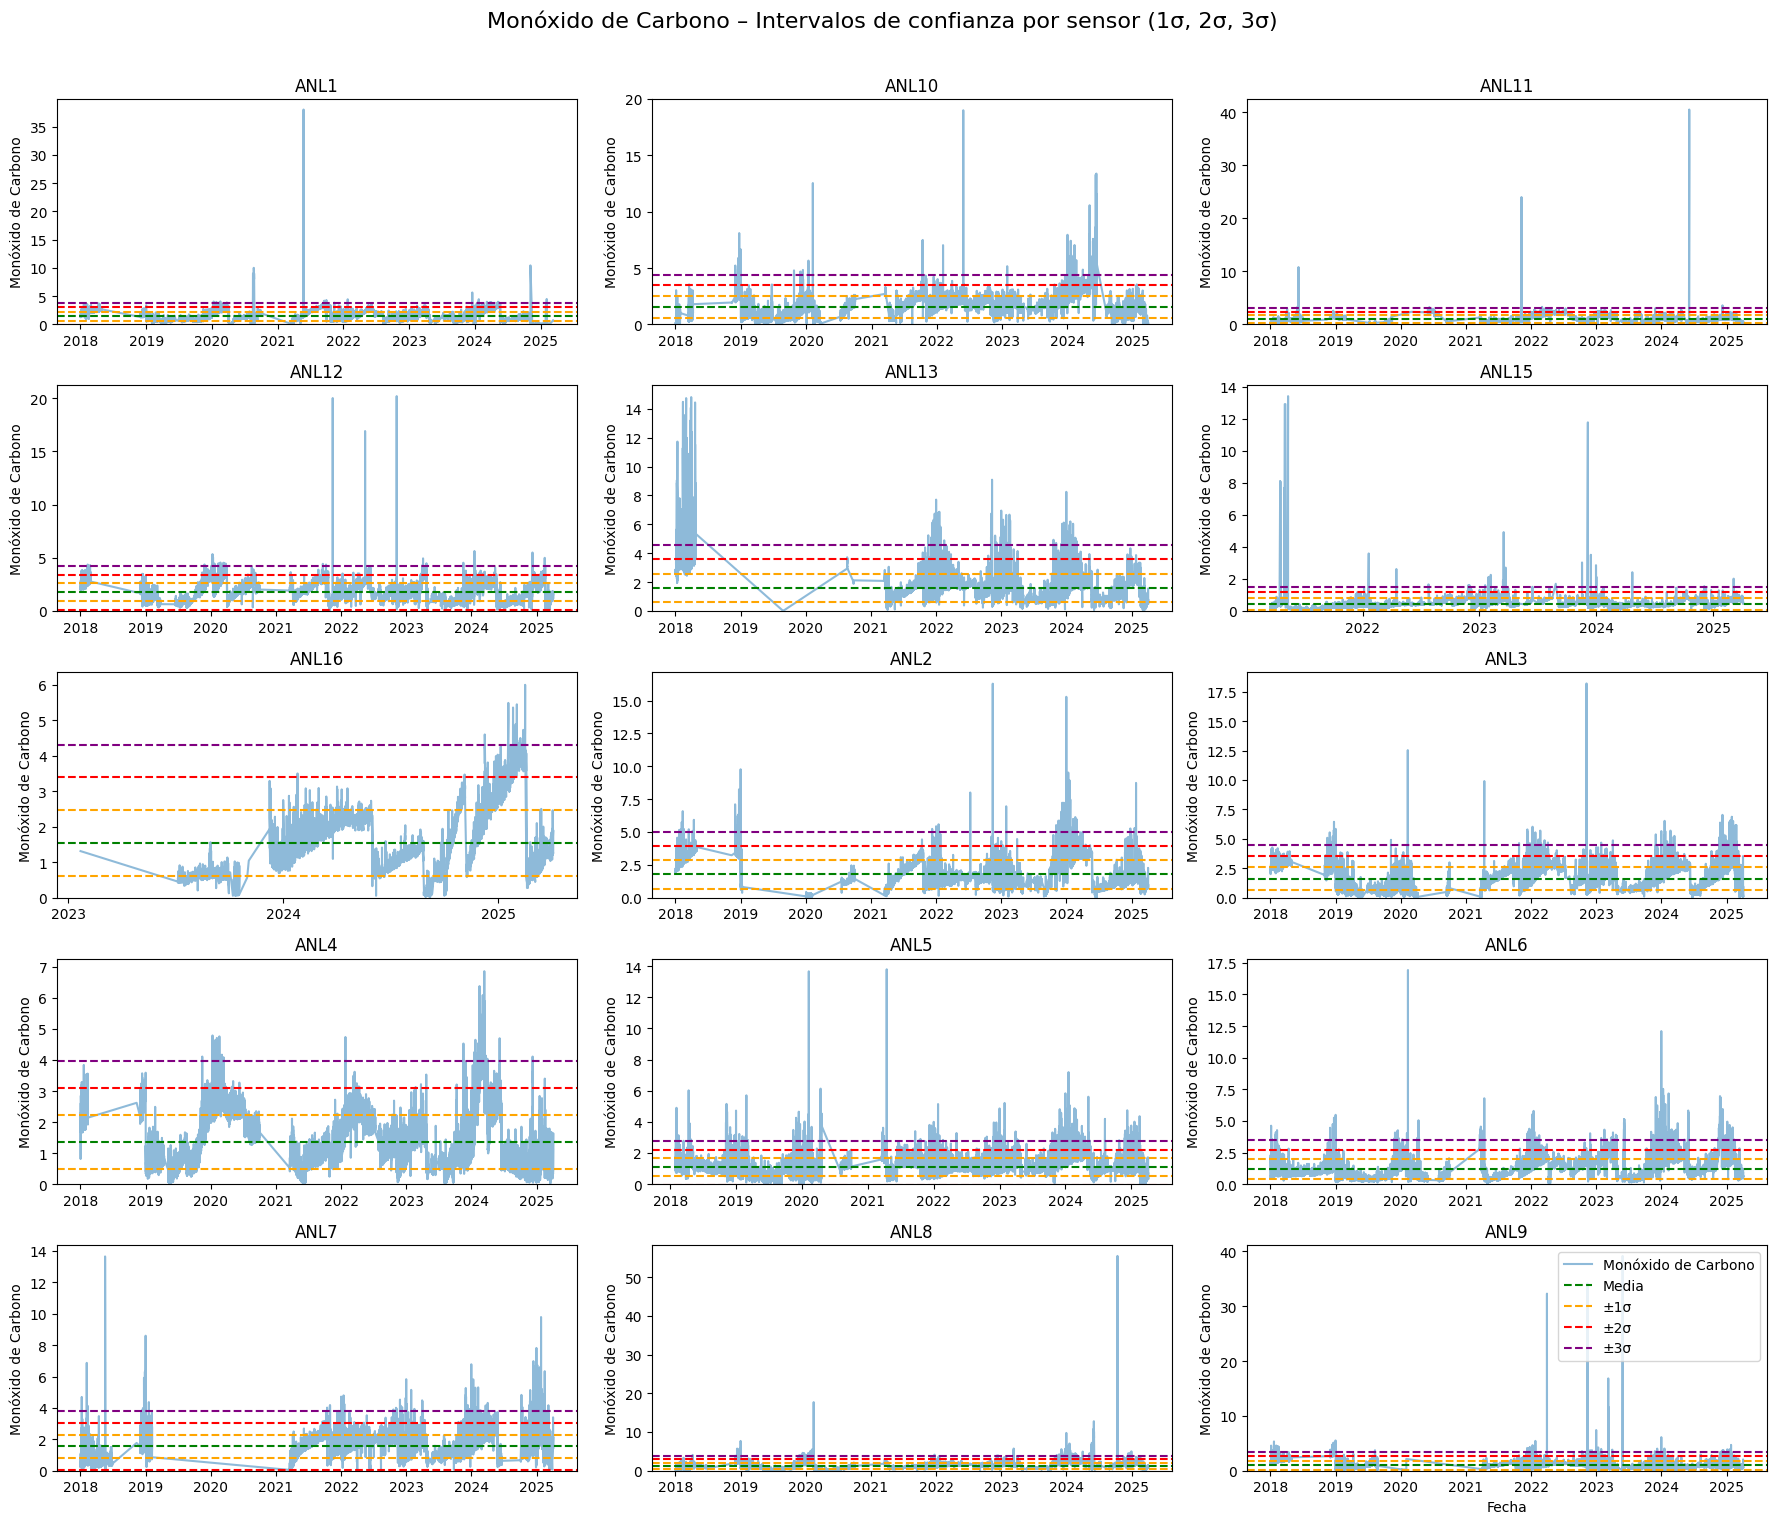

In [97]:
graficar_intervalos_confianza(registros_filtrados, sensores, "CO", "Monóxido de Carbono")

# Contaminante NO1

## Calidad de los Datos – NO1

In [98]:
resumen_calidad_sensor(registros_filtrados, "NO1", "Monóxido de Nitrógeno")

Resumen de calidad – Monóxido de Nitrógeno


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL7,56837,38376,0,67.52,0.00
ANL6,56834,36996,1,65.09,0.00
ANL1,56839,36992,1,65.08,0.00
ANL12,56853,36843,3,64.80,0.01
ANL9,56863,36633,1,64.42,0.00
ANL11,56858,36283,3,63.81,0.01
ANL13,56853,36241,1,63.75,0.00
ANL3,56820,36111,3,63.55,0.01
ANL5,56830,36078,2,63.48,0.00


## Distribución - NO1

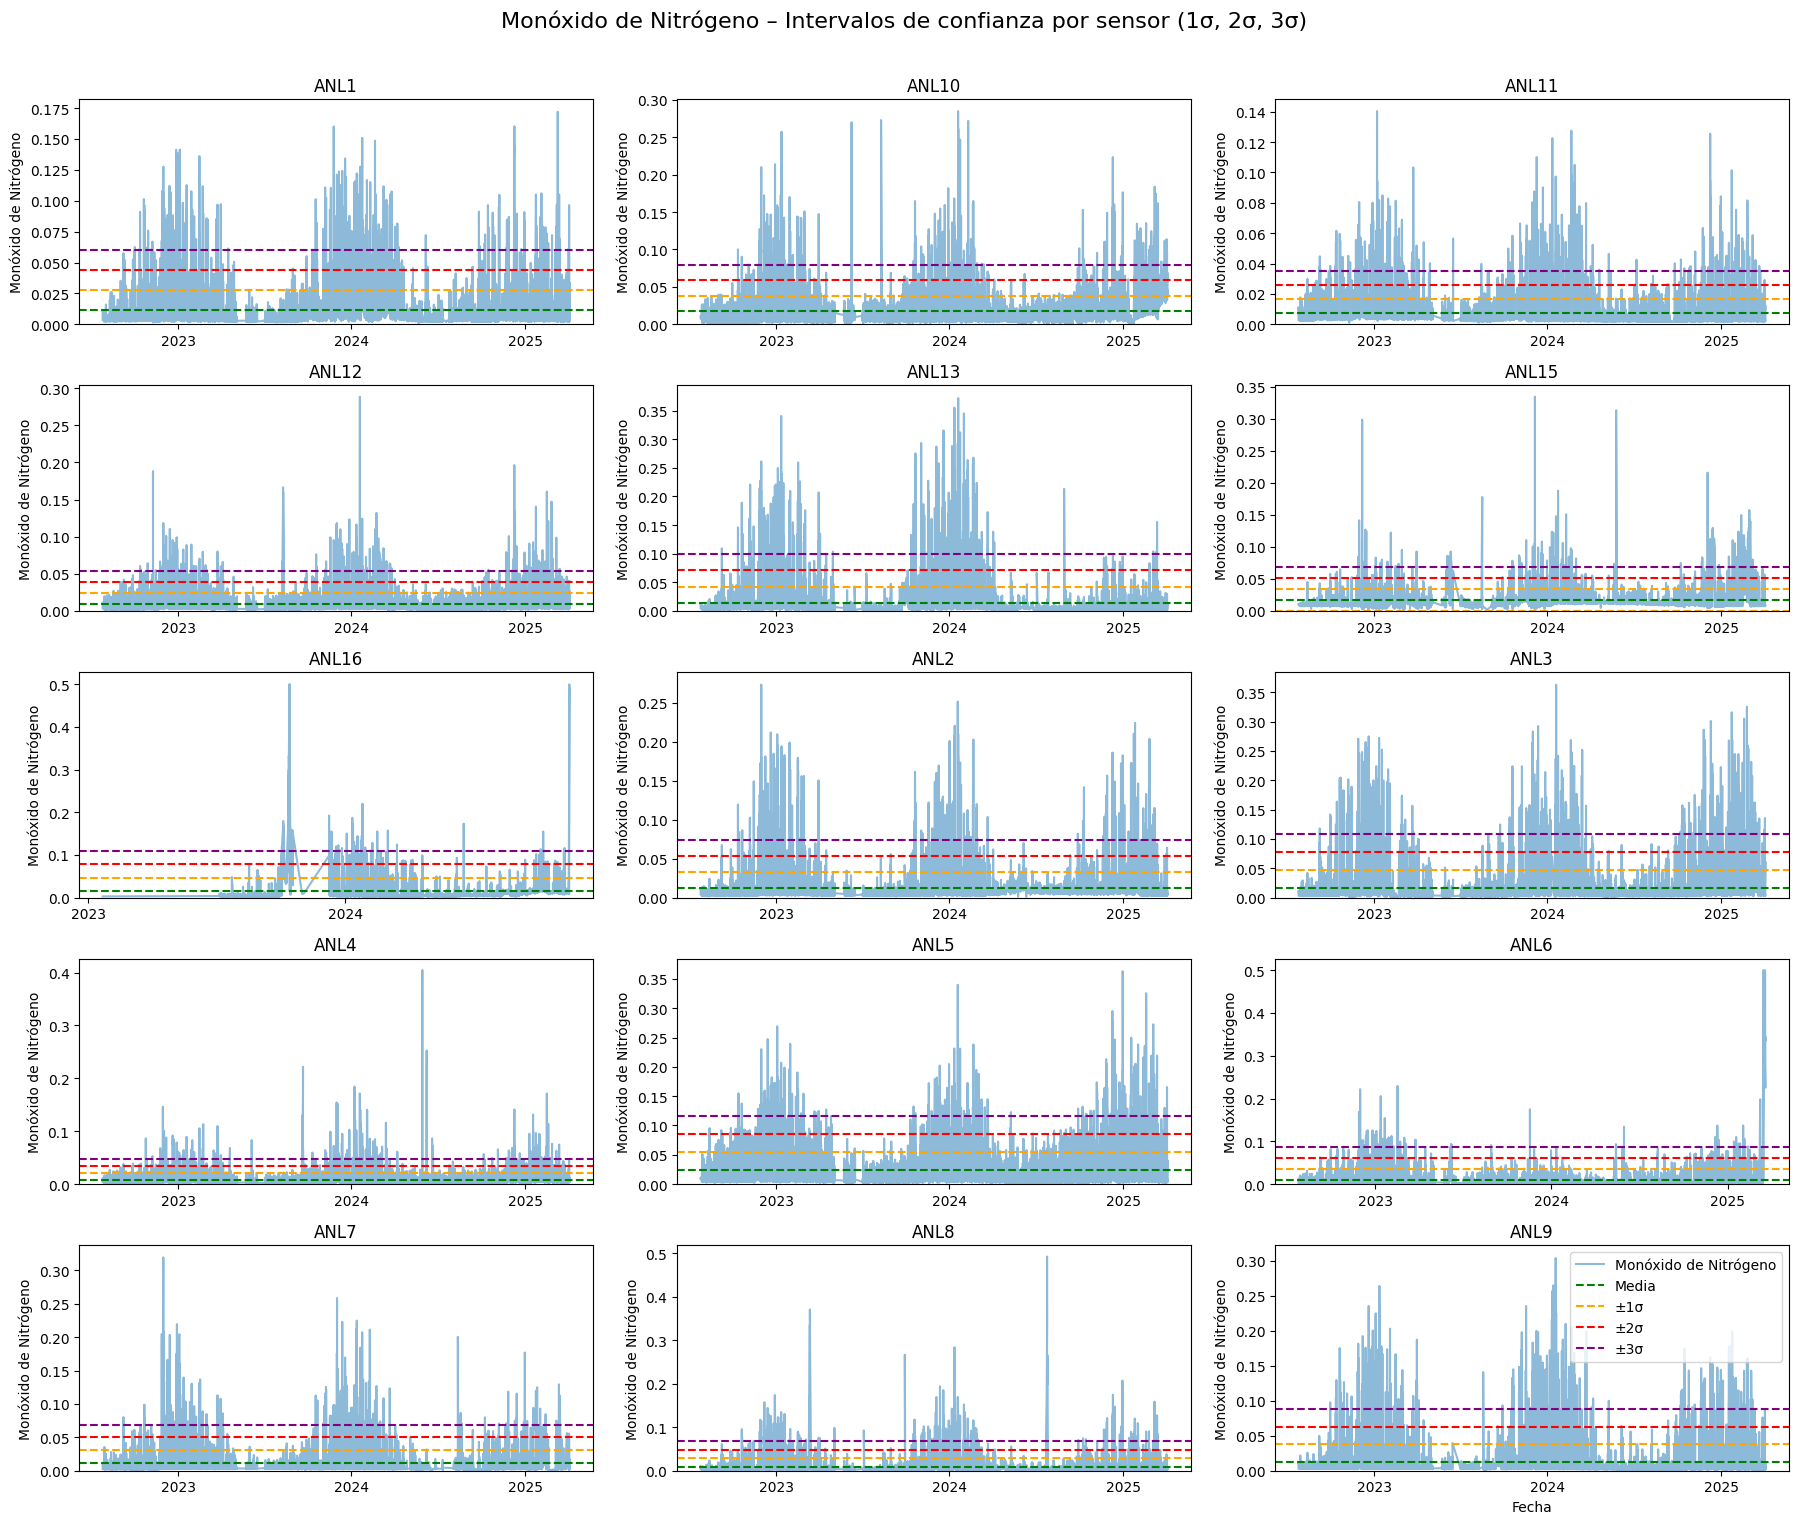

In [99]:
graficar_intervalos_confianza(registros_filtrados, sensores, "NO1", "Monóxido de Nitrógeno")

# Contaminante NO2

## Calidad de los Datos – NO2

In [100]:
resumen_calidad_sensor(registros_filtrados, "NO2", "Dióxido de Nitrógeno")

Resumen de calidad – Dióxido de Nitrógeno


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL9,56863,26788,1,47.11,0.00
ANL1,56839,26549,1,46.71,0.00
ANL7,56837,26000,3,45.74,0.01
ANL10,56866,25899,3,45.54,0.01
ANL2,56835,25176,0,44.30,0.00
ANL13,56853,23348,1,41.07,0.00
ANL11,56858,22826,4,40.15,0.01
ANL6,56834,22028,3,38.76,0.01
ANL3,56820,19110,4,33.63,0.01


## Distribución - NO2

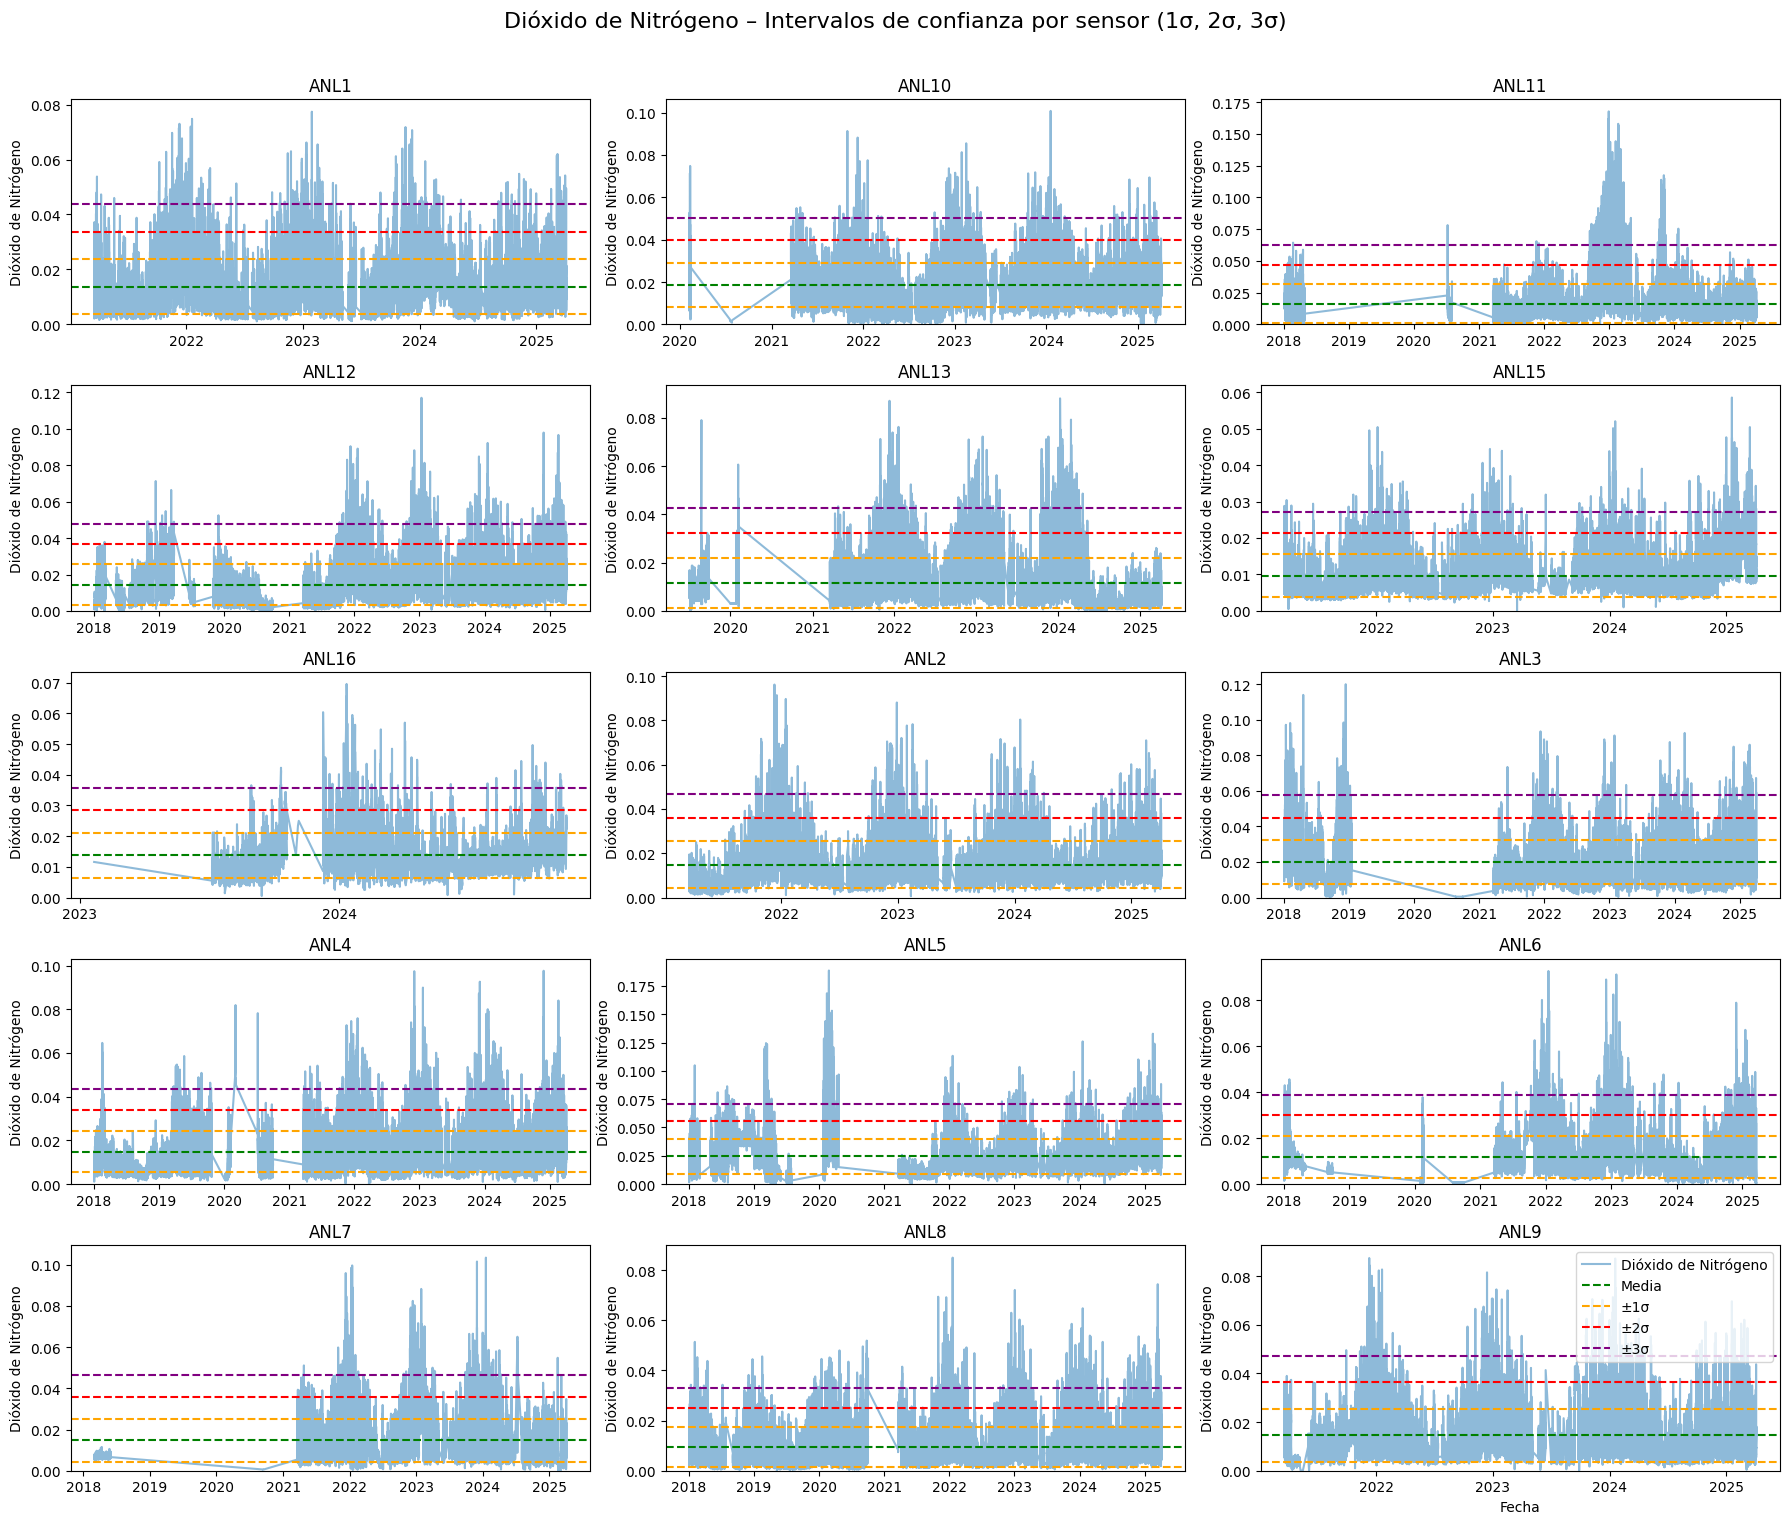

In [101]:
graficar_intervalos_confianza(registros_filtrados, sensores, "NO2", "Dióxido de Nitrógeno")

# Contaminante NOx

## Calidad de los Datos – NO2

In [102]:
resumen_calidad_sensor(registros_filtrados, "NOx", "Óxidos de Nitrógeno")

Resumen de calidad – Óxidos de Nitrógeno


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL7,56837,37768,0,66.45,0.00
ANL6,56834,36630,1,64.45,0.00
ANL1,56839,36489,1,64.20,0.00
ANL9,56863,36147,1,63.57,0.00
ANL5,56830,36065,2,63.46,0.00
ANL3,56820,36003,3,63.36,0.01
ANL10,56866,35986,1,63.28,0.00
ANL12,56853,35966,3,63.26,0.01
ANL11,56858,35799,3,62.96,0.01


## Distribución - NOx

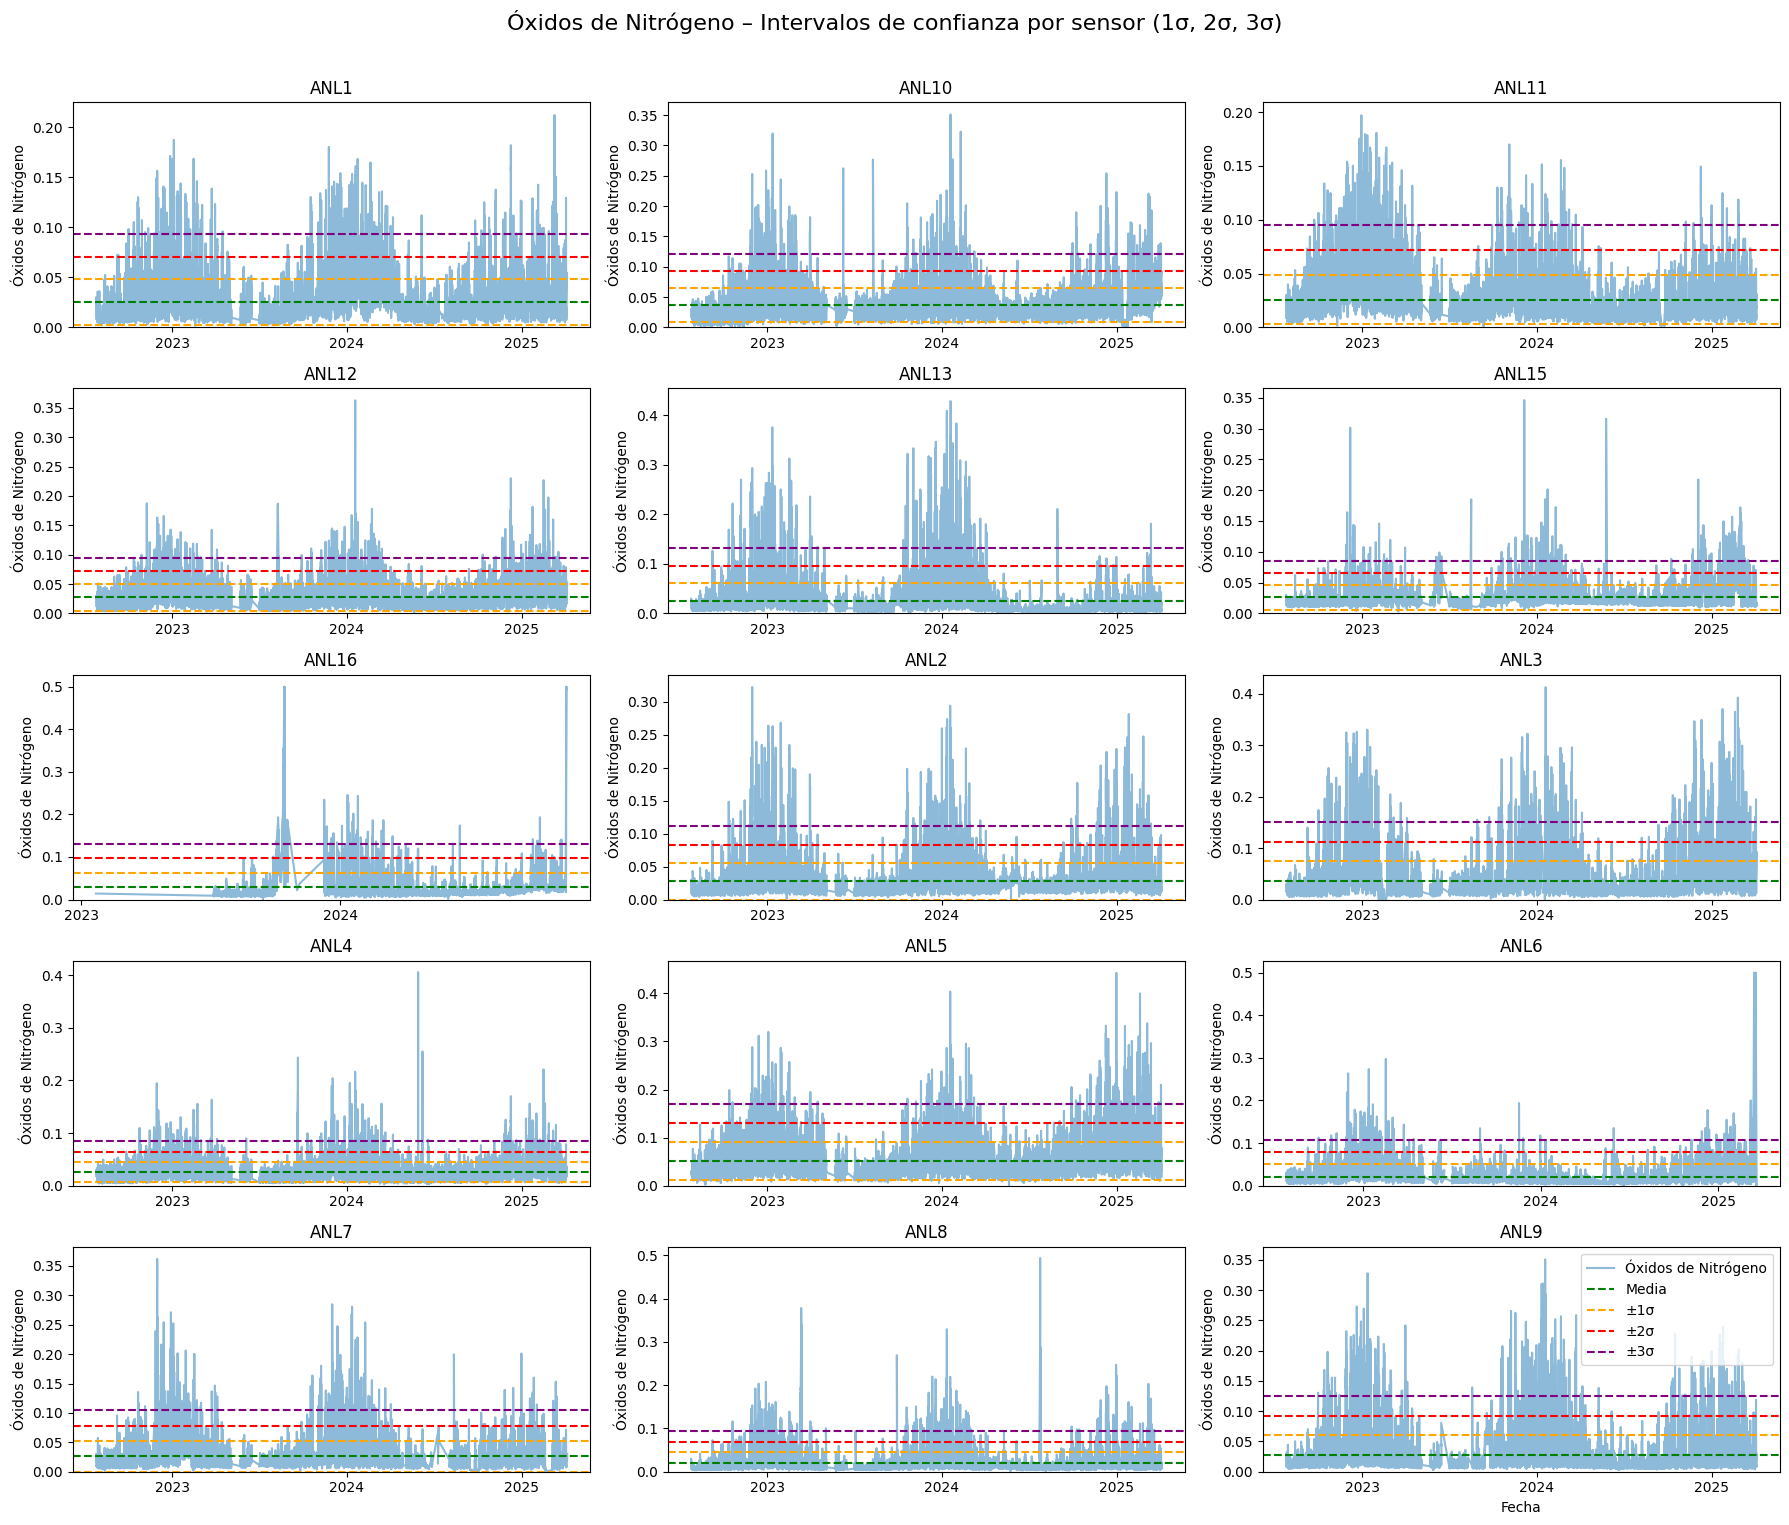

In [103]:
graficar_intervalos_confianza(registros_filtrados, sensores, "NOx", "Óxidos de Nitrógeno")

# Contaminante SO2

## Calidad de los Datos – SO2

In [104]:
resumen_calidad_sensor(registros_filtrados, "SO2", "Dióxido de Azufre")

Resumen de calidad – Dióxido de Azufre


,Total registros,Nulos,Inconsistentes (<0),% Nulos,% Inconsistentes
Sensor_id,,,,,
ANL9,56863,27441,3,48.26,0.01
ANL10,56866,23827,1,41.90,0.00
ANL6,56834,22215,3,39.09,0.01
ANL15,32743,12511,336,38.21,1.03
ANL7,56837,21022,0,36.99,0.00
ANL12,56853,16291,3,28.65,0.01
ANL13,56853,15890,2,27.95,0.00
ANL5,56830,12260,12,21.57,0.02
ANL11,56858,11109,4,19.54,0.01


## Distribución - SO2

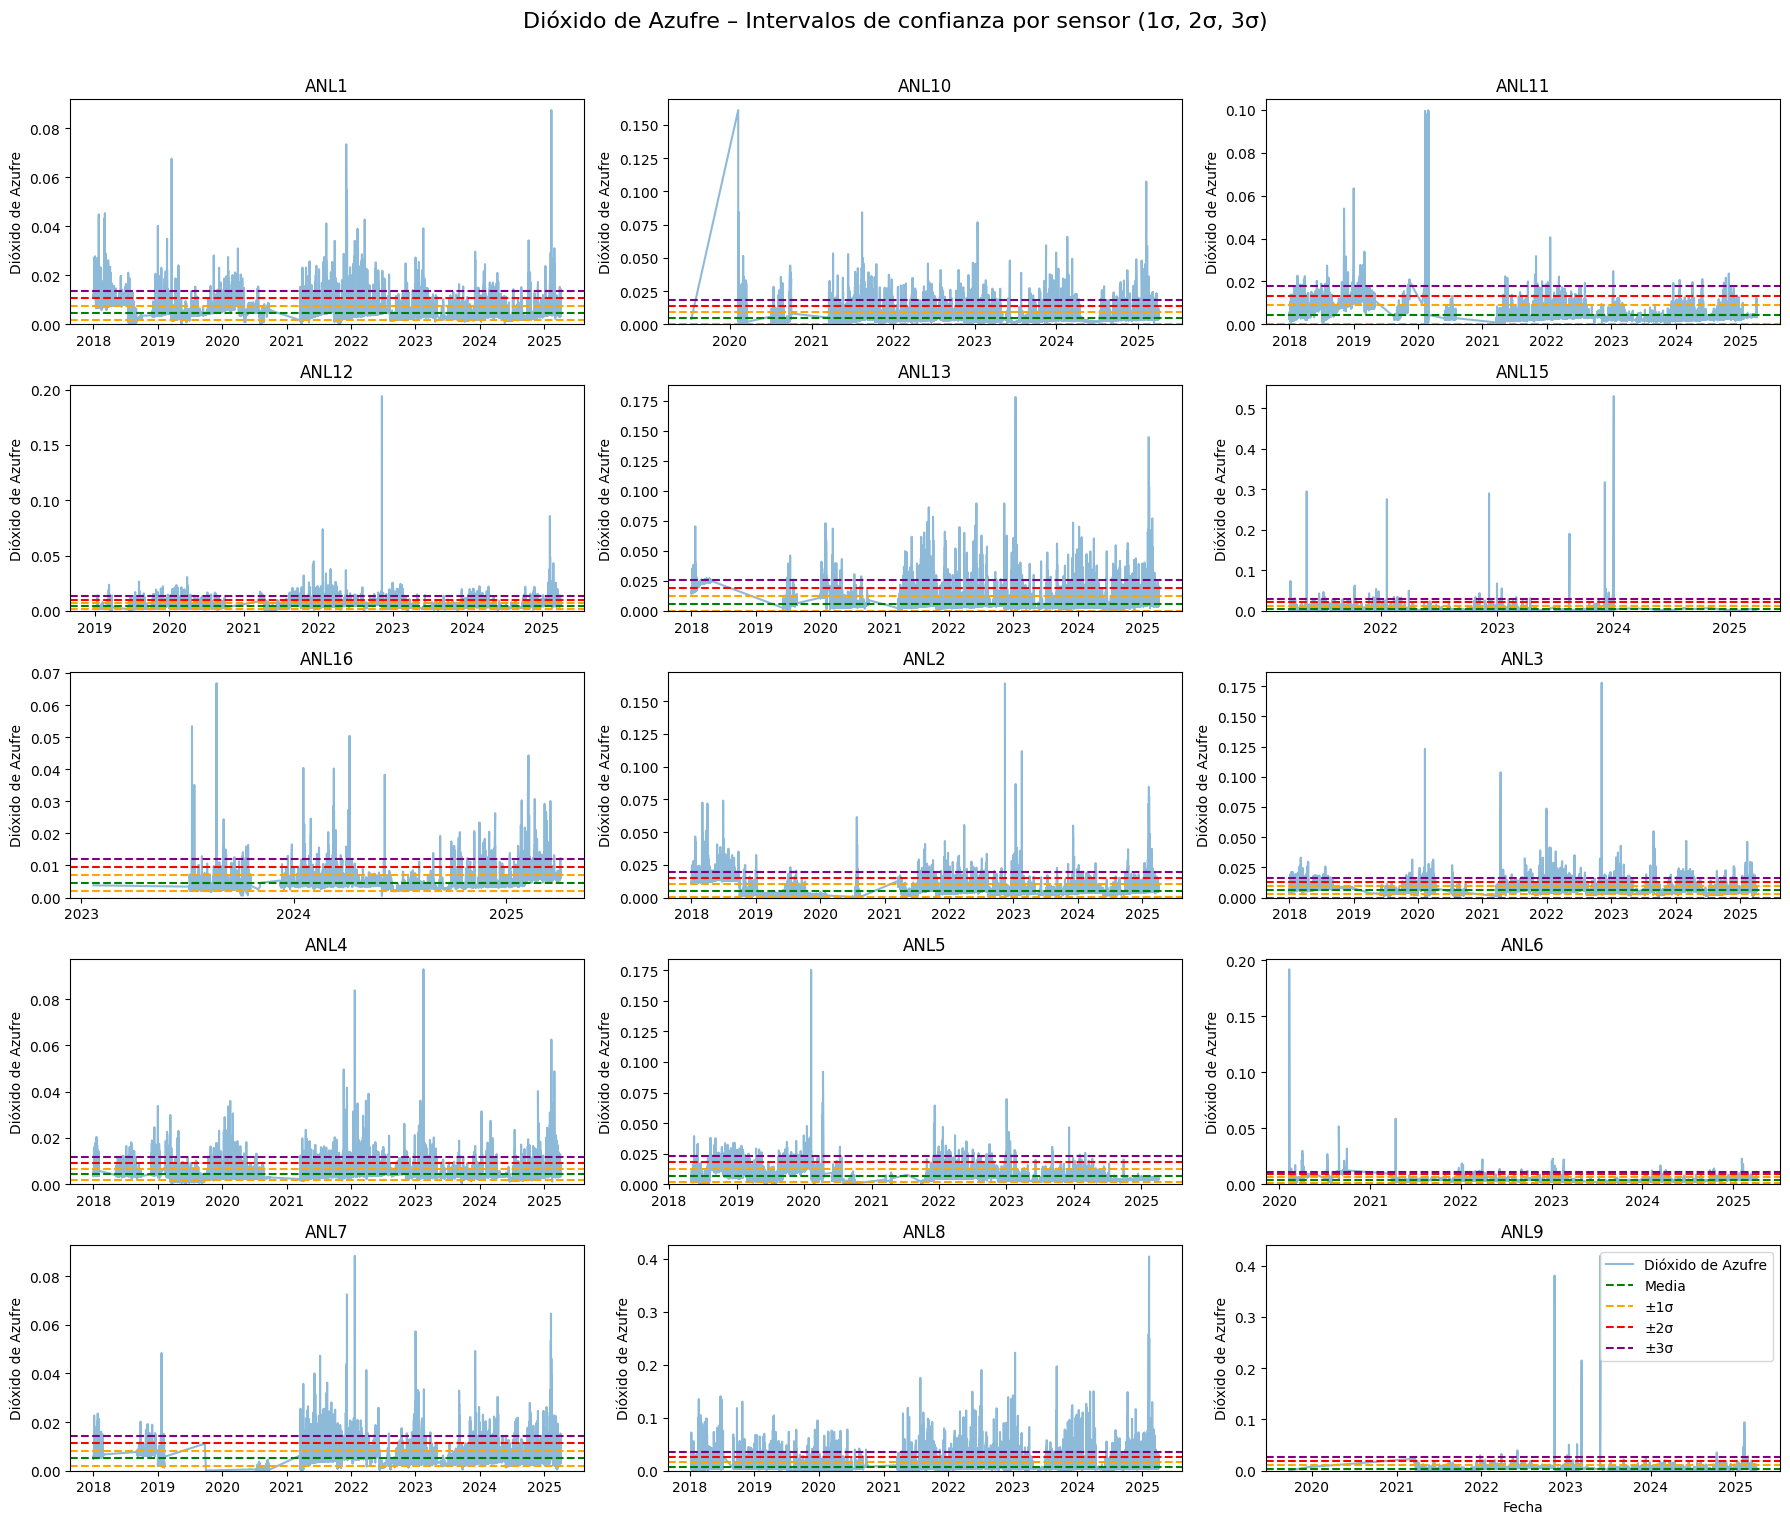

In [105]:
graficar_intervalos_confianza(registros_filtrados, sensores, "SO2", "Dióxido de Azufre")

## Posibles causas de pérdida de datos

Durante el análisis de calidad de los registros, se observaron porcentajes variables de datos faltantes y lecturas inconsistentes (como valores negativos) en múltiples sensores ANL. Estas pérdidas de información pueden deberse a varias causas operativas y técnicas, entre ellas:

- **Fallas temporales en el hardware de los sensores**, incluyendo bloqueos en las interfaces de adquisición o interrupciones de energía.
- **Periodos de mantenimiento o calibración de los sensores**, en los cuales se suspende temporalmente la toma de muestras.
- **Problemas de comunicación o transmisión de datos**, especialmente si los sensores dependen de conectividad celular o inalámbrica.
- **Condiciones ambientales adversas**, como lluvias intensas o temperaturas extremas, que pueden afectar la estabilidad de lectura o desconectar sensores.

Estas posibles causas también han sido mencionadas en otros estudios. Por ejemplo, Zhang et al. (2017) señalan que si los sensores no reciben mantenimiento regular o se exponen por mucho tiempo a humedad, pueden fallar de forma constante.
Por otro lado, Hasenfratz et al. (2012) explican que en sensores móviles o instalados en entornos urbanos, es común tener problemas de transmisión o pérdida de precisión conforme pasa el tiempo, lo que interrumpe la captura continua de datos.

# Representatividad Geográfica de las Mediciones

El área metropolitana de Monterrey abarca aproximadamente 6,680 km² e incluye municipios como Monterrey, San Pedro Garza García, Santa Catarina, Apodaca, Escobedo, Guadalupe y San Nicolás.

Los sensores ANL están distribuidos en diferentes puntos de esta zona, sin embargo, algunos municipios cuentan con más cobertura que otros. En promedio, cada sensor cubre una extensión territorial de más de 400 km², aunque su alcance real depende de factores como viento, orografía y densidad urbana.

En el siguiente mapa se muestran las ubicaciones de los sensores ANL sobre un fondo que delimita los municipios metropolitanos, lo cual permite visualizar qué zonas están mejor cubiertas y cuáles podrían requerir refuerzo.

In [106]:
municipios = gpd.read_file("municipios.geojson")
mapa = folium.Map(location=[25.67, -100.31], zoom_start=10, min_zoom=10, tiles="CartoDB positron")

# Limites de los municipios
folium.GeoJson(
    municipios,
    name="Municipios",
    style_function=lambda x: {
        'fillColor': '#eeeeee',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.2
    },
    tooltip=folium.GeoJsonTooltip(fields=["NOMBRE"])
).add_to(mapa)

# Agregar sensores 
for _, row in sensores.iterrows():
    folium.CircleMarker(
        location=[row["Latitud"], row["Longitud"]],
        radius=5,
        color="blue",
        fill=True,
        fill_opacity=0.8,
        popup=row["Sensor_id"]
    ).add_to(mapa)

mapa


## Alcance Territorial de las Mediciones

La distribución geográfica de los sensores en el área metropolitana de Monterrey muestra una cobertura desigual entre municipios. Monterrey, García y San Nicolás de los Garza concentran la mayor cantidad de sensores, lo que permite un monitoreo más denso y confiable en esas zonas. En contraste, municipios como Santa Catarina, Pesquería o Cadereyta Jiménez cuentan con una cobertura mucho más limitada, con un sensor dentro de su territorio.

Esta asimetría puede generar sesgos en el análisis de la calidad del aire, especialmente al hacer estimaciones regionales. Considerando que un sensor de gama media tiene un rango de medición representativa de aproximadamente 1 a 3 kilómetros en zonas urbanas (dependiendo de condiciones topográficas y meteorológicas), zonas como el centro de Monterrey podrían tener buena redundancia, mientras que áreas periféricas podrían presentar vacíos de información. Esto implica que algunas comunidades podrían estar subrepresentadas en el monitoreo ambiental. Por ello, es importante interpretar los datos considerando tanto la ubicación como la densidad de los sensores, e incluso evaluar estrategias futuras de expansión que optimicen la representatividad espacial.